In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from IPython import display
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [4]:
num_batches = len(train_loader)

In [5]:
# https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
    

class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [6]:
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet().to(device)

In [7]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 201

In [8]:
  def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [9]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)

    error_real = loss(prediction_real, torch.ones(real_data.size(0),1,device=device))
    error_real.backward()

    prediction_fake = discriminator(fake_data)

    error_fake = loss(prediction_fake, torch.zeros(real_data.size(0),1,device=device))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    error = loss(prediction, torch.ones(real_data.size(0),1,device=device))
    error.backward()

    optimizer.step()

    return error

In [10]:
num_test_samples = 16
d = 100
test_noise = torch.randn(num_test_samples, 100, device=device)

In [11]:
def val_test(test_image):
    fig, ax = plt.subplots(2,8,figsize=(15,7))
    for k in range(16):
        i = k%2
        j = k//2
        ax[i,j].imshow(test_image[k][0],"gray")
    plt.show()

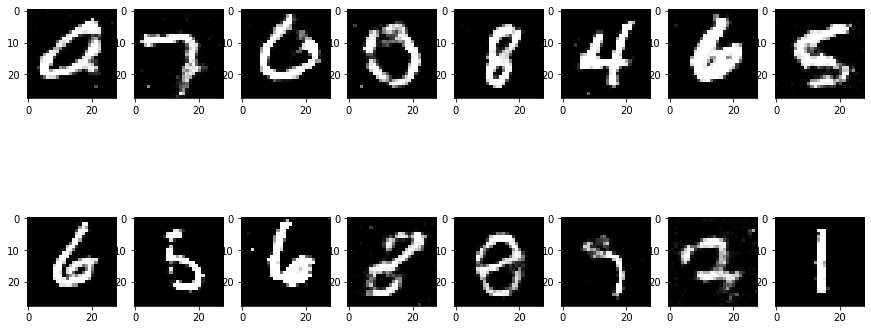

In [12]:
for epoch in range(num_epochs):
    g_loss = []
    d_loss = []

    for n_batch, (real_batch,_) in enumerate(train_loader):

        # Train Discriminator
        # real_data = Variable(images_to_vectors(real_batch)).to(device)
        real_data = real_batch.view(-1,28*28).to(device)
        fake_data = generator(torch.randn(real_data.size(0), 100, device=device)).detach()        
        d_error = train_discriminator(d_optimizer, real_data, fake_data)

        # Train Generator
        fake_data = generator(torch.randn(real_batch.size(0), 100, device=device, requires_grad=True))
        g_error = train_generator(g_optimizer, fake_data)

        d_loss.append(d_error.item())
        g_loss.append(g_error.item())

    print(epoch, np.mean(d_loss), d_loss[-1], np.mean(g_loss), g_loss[-1])

    if epoch % 50 == 0:
        display.clear_output(True)
        # test_images = vectors_to_images(generator(test_noise)).data.cpu()
        test_images = generator(test_noise).view(-1,1,28,28).data.cpu()

        val_test(test_images)
